In [68]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api
import scipy
import statsmodels
from sklearn.base import clone
import doubleml as dml
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, Lasso
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000

In [69]:
#load data
df_log=pd.read_csv("dataframe_transformed_4_log.csv")
# df_log.drop("Unnamed: 0", axis=1, inplace=True)

In [70]:
# short data transformation:

# #for models that cannot handle NaN values: need to replace missing/zero observations:
# #largest value of column in stead of -infinity (same for both) to impute: because the week before was a promo (therefore obs = 0, therefore log(0)=-inf)
# maxt1= df_log[df_log['L_PRODUCT_ORDER_AMT_T_1']>df_log['L_PRODUCT_ORDER_AMT_T_1'].min()]['L_PRODUCT_ORDER_AMT_T_1'].max()
# maxt2=df_log[df_log['L_PRODUCT_ORDER_AMT_T_2']>df_log['L_PRODUCT_ORDER_AMT_T_2'].min()]['L_PRODUCT_ORDER_AMT_T_2'].max()
# #create new column with imputed value in stead of -infty
# df_log['L_PRODUCT_ORDER_AMT_T_2_m']=df_log['L_PRODUCT_ORDER_AMT_T_2'].copy()
# df_log['L_PRODUCT_ORDER_AMT_T_2_m'].replace([np.inf, -np.inf, np.nan], maxt1, inplace=True)
# df_log['L_PRODUCT_ORDER_AMT_T_1_m']=df_log['L_PRODUCT_ORDER_AMT_T_1'].copy()
# df_log['L_PRODUCT_ORDER_AMT_T_1_m'].replace([np.inf, -np.inf, np.nan], maxt2, inplace=True)
# include dummy for holidays and other special dates that can explain irregular demand


listofHolidays=["2020-12-28",
                "2021-01-04",
                "2021-03-29",
                "2021-05-03",
                "2021-07-26",
                "2021-08-02",
                "2021-08-09",
                "2021-08-16",
                "2021-12-27",
                "2022-01-03",
                "2022-04-11",
                "2022-05-02",
                "2022-07-25",
                "2022-08-01",
                "2022-08-08",
                "2022-08-15",
                "2022-12-26"
                ]
df_log['HOLIDAY']=(df_log['WEEK_START_DATE'].isin(listofHolidays))*1

# transformed the week number variable -> but decided that you want non-log-transformed version of this variable.
# non-log-transformed week number because:do not need interpretation of log-log which would be: "percentage increase in week number leads to percentage change in demand"
# but we want interpretation of absolute increase in weeks (inflation measure) on --> effect on % demand
df_log['WEEK_NR']=np.round(np.exp(df_log['L_WEEK_NR']))

In [71]:
#xgboost can handle np.nan (instead of -inf): 
df=df_log.copy()
df.replace([-np.inf], np.nan, inplace=True)

Create variable to filter on: (from dummy to categorical)

In [72]:
df.columns

Index(['KEY_ARTICLE', 'KEY_WEEK', 'L_PRODUCT_ORDER_AMT', 'CONST',
       'L_PRODUCT_ORDER_AMT_T_1', 'L_AVG_SELL_PRICE_T_1',
       'L_PRODUCT_ORDER_AMT_T_2', 'L_AVG_SELL_PRICE_T_2', 'PPL2', 'PPL3',
       'YEAR_CALENDAR_WEEK', 'WEEK_START_DATE', 'ARTICLE_NAME', 'ARTICLE_ID',
       'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD',
       'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL',
       'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK',
       'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK',
       'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN',
       'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS',
       'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK',
       'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL1', 'POSTPPL1', 'POSTPPL2',
       'POSTPPL3', 'L_AVG_SELL_PRICE', 'L_AVG_SELL_PRICE_SQ',
       'L_AVG_PURCHASE_PRICE', 'L_AVG_PURCHASE_PRICE_SQ', 'L_AVG_HIGH_TEMP',
       'L_AVG_HIGH_TEMP_SQ', 'L_TOTAL_ORDER_AMT',

In [73]:
# Would be easiest to use categorical variable: for now memory is full so manually transform dummy variables back to categorical variables
# Combine the dummy variables into a single categorical variable
df['ART_CAT_2'] = df.apply(lambda x: 'Drinkpakjes' if x['ARTICLE_CAT_2_DRINKPAKJES'] == 1 else
                                 ('Fruitdrank' if x['ARTICLE_CAT_2_FRUITDRANK'] == 1 else
                                 ('Ijsthee' if x['ARTICLE_CAT_2_IJSTHEE'] == 1 else
                                 ('Limonade & siropen' if x['ARTICLE_CAT_2_LIMONADE_SIROPEN'] == 1 else
                                 ('Sappen & smoothies' if x['ARTICLE_CAT_2_SAPPEN_SMOOTHIES'] == 1 else
                                 ('Sinas, Lemon & Cassis' if x['ARTICLE_CAT_2_SINAS_LEMON_CASSIS'] == 1 else
                                 ('Speciaal fris' if x['ARTICLE_CAT_2_SPECIAAL_FRIS'] == 1 else
                                 ('Sport- & energydrink' if x['ARTICLE_CAT_2_SPORT_ENERGYDRINK'] == 1 else
                                 ('Water' if x['ARTICLE_CAT_2_WATER'] == 1 else 'Cola')))))))), axis=1)

In [74]:
df['ART_CAT_2'].value_counts()

Fruitdrank               13694
Sappen & smoothies       11049
Speciaal fris             8867
Cola                      7938
Limonade & siropen        7700
Drinkpakjes               7352
Sinas, Lemon & Cassis     4906
Water                     4017
Sport- & energydrink      1206
Ijsthee                   1182
Name: ART_CAT_2, dtype: int64

In [75]:
#create data partition you will use in methods

x_0 = df[['ART_CAT_2',
       'CONST','ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD',
       'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL',
       'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK',
       'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK',
       'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN',
       'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS',
       'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK',
       'ARTICLE_CAT_2_WATER', 
       'PROMO_DUMMY', 
       'PPL2','PPL3', 'POSTPPL1', 'POSTPPL2','POSTPPL3', 
       'L_AVG_HIGH_TEMP',#'L_TOTAL_ORDER_AMT',
       'L_NR_ARTICLES_IN_CAT', 
       'L_NR_ARTICLES_IN_CAT_2', # 'L_WEEK_NR',
       'AVG_UNAVAILABILITY_PERC',
       'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 
       # 'L_PRODUCT_ORDER_AMT_T_2_m','L_PRODUCT_ORDER_AMT_T_1_m' ,
       # 'L_PRODUCT_ORDER_AMT_T_1', 'L_PRODUCT_ORDER_AMT_T_2',
       #'L_AVG_PURCHASE_PRICE',
       'HOLIDAY','WEEK_NR'
       ]]
x=x_0.drop('ART_CAT_2',axis=1)

y = df['L_PRODUCT_ORDER_AMT']
p = df['L_AVG_SELL_PRICE']
z = df['L_AVG_PURCHASE_PRICE']

naiveset=x_0.join(p.to_frame()) 
dmlset=x_0.join(y.to_frame().join(p.to_frame().join(z.to_frame()))) #needed in dml algortihm

Test set size smaller in this case: as datasets are smaller

In [76]:
x_0train, x_0test,x_train, x_test, y_train, y_test, p_train, p_test, z_train, z_test, naiveset_train, naiveset_test, dmlset_train, dmlset_test = train_test_split(x_0,x,y,p,z,naiveset, dmlset,random_state=44, test_size=0.2) #in case want to see how first stages perform

# Naive methods

OLS

In [77]:
from linearmodels.iv import IV2SLS

# Define what column to filter on
subset_col='ART_CAT_2'

# Get the unique values of the column that we want to use for dividing the subsets
unique_values = dmlset_train[subset_col].unique()
# Store the results of each subset in a dictionary
results1a = {}
for value in unique_values:
    print("Running for", value,"...")
    subset = dmlset_train[dmlset_train[subset_col] == value]
    res_ols = IV2SLS(dmlset_train['L_PRODUCT_ORDER_AMT'], dmlset_train.drop(['ART_CAT_2','L_PRODUCT_ORDER_AMT','L_AVG_PURCHASE_PRICE'],axis=1), None, None).fit(cov_type="unadjusted")
    result = res_ols
    # Store the result of the model operation in the dictionary
    results1a[value] = result

# Print all the results
for key, value in results1a.items():
    print(f"Result for value {key}: {value}")

Running for Limonade & siropen ...
Running for Cola ...
Running for Fruitdrank ...
Running for Drinkpakjes ...
Running for Sappen & smoothies ...
Running for Sport- & energydrink ...
Running for Ijsthee ...
Running for Speciaal fris ...
Running for Water ...
Running for Sinas, Lemon & Cassis ...
Result for value Limonade & siropen:                              OLS Estimation Summary                            
Dep. Variable:     L_PRODUCT_ORDER_AMT   R-squared:                      0.3532
Estimator:                         OLS   Adj. R-squared:                 0.3528
No. Observations:                54328   F-statistic:                 2.966e+04
Date:                 Thu, Mar 16 2023   P-value (F-stat)                0.0000
Time:                         17:40:12   Distribution:                 chi2(31)
Cov. Estimator:             unadjusted                                         
                                                                               
                          

TSLS

In [78]:
from linearmodels.iv import IV2SLS

# Define what column to filter on
subset_col='ART_CAT_2'

# Get the unique values of the column that we want to use for dividing the subsets
unique_values = dmlset_train[subset_col].unique()
# Store the results of each subset in a dictionary
results1b = {}
for value in unique_values:
    print("Running for", value,"...")
    subset = dmlset_train[dmlset_train[subset_col] == value]
    res_ols = IV2SLS(dmlset_train['L_PRODUCT_ORDER_AMT'], dmlset_train.drop(['ART_CAT_2','L_PRODUCT_ORDER_AMT','L_AVG_PURCHASE_PRICE','L_AVG_SELL_PRICE'],axis=1), dmlset_train['L_AVG_SELL_PRICE'], dmlset_train['L_AVG_PURCHASE_PRICE']).fit(cov_type="unadjusted")
    result = res_ols.summary
    # Store the result of the model operation in the dictionary
    results1b[value] = result

# Print all the results
for key, value in results1b.items():
    print(f"Result for value {key}: {value}")

Running for Limonade & siropen ...
Running for Cola ...
Running for Fruitdrank ...
Running for Drinkpakjes ...
Running for Sappen & smoothies ...
Running for Sport- & energydrink ...
Running for Ijsthee ...
Running for Speciaal fris ...
Running for Water ...
Running for Sinas, Lemon & Cassis ...
Result for value Limonade & siropen:                            IV-2SLS Estimation Summary                          
Dep. Variable:     L_PRODUCT_ORDER_AMT   R-squared:                      0.3528
Estimator:                     IV-2SLS   Adj. R-squared:                 0.3525
No. Observations:                54328   F-statistic:                 2.861e+04
Date:                 Thu, Mar 16 2023   P-value (F-stat)                0.0000
Time:                         17:40:21   Distribution:                 chi2(31)
Cov. Estimator:             unadjusted                                         
                                                                               
                          

# DML-PLIV

Rfor:

In [79]:
Learnerml_l= RandomForestRegressor(max_features=0.65, n_estimators=500)
Learnerml_m= RandomForestRegressor(max_features=0.65, n_estimators=500)
Learnerml_r= RandomForestRegressor(max_features=0.65, n_estimators=500)

In [80]:
# Define what column to filter on
subset_col='ART_CAT_2'

# Get the unique values of the column that we want to use for dividing the subsets
unique_values = dmlset_train[subset_col].unique()
# Store the results of each subset in a dictionary
results2 = {}
for value in unique_values:
    print("Running for", value,"...")
    subset = dmlset_train[dmlset_train[subset_col] == value]
    # Perform the model operation on the subset
    Learnerml_l.fit(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE','L_AVG_SELL_PRICE','L_PRODUCT_ORDER_AMT'],axis=1), subset['L_PRODUCT_ORDER_AMT'])
    Learnerml_r.fit(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE','L_AVG_SELL_PRICE','L_PRODUCT_ORDER_AMT'],axis=1), subset['L_AVG_SELL_PRICE'])
    Learnerml_m.fit(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE','L_AVG_SELL_PRICE','L_PRODUCT_ORDER_AMT'],axis=1), subset['L_AVG_PURCHASE_PRICE'])
    obj_dml_data = dml.DoubleMLData(subset.drop('ART_CAT_2',axis=1), y_col='L_PRODUCT_ORDER_AMT', d_cols='L_AVG_SELL_PRICE', z_cols='L_AVG_PURCHASE_PRICE',  force_all_x_finite=True)
    #print(obj_dml_data)
    dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, Learnerml_l, Learnerml_m, Learnerml_r)
    print(dml_pliv_obj.fit())
    result = dml_pliv_obj.coef
    # Store the result of the model operation in the dictionary
    results2[value] = result

# Print all the results
for key, value in results2.items():
    print(f"Result for value {key}: {value}")

Running for Limonade & siropen ...


XGBoost

Create data set again - now the NaN values can be used so other columns are selected

Test set size smaller in this case: as datasets are smaller

In [ ]:
#Initialize XGBoost (Parameters Optimized Elsewhere)
xgbr_l=xgb.XGBRegressor(colsample_bytree= 1, gamma= 0, learning_rate= 0.2, max_depth= None, n_estimators= 500)
xgbr_m=xgb.XGBRegressor(colsample_bytree= 1, gamma= 0, learning_rate= 0.2, max_depth= None, n_estimators= 500)
xgbr_r=xgb.XGBRegressor(colsample_bytree= 1, gamma= 0, learning_rate= 0.2, max_depth= None, n_estimators= 500)


Second stage: (which will be executed for each subset)

In [ ]:
# Define what column to filter on
subset_col='ART_CAT_2'

# Get the unique values of the column that we want to use for dividing the subsets
unique_values = dmlset_train[subset_col].unique()
# Store the results of each subset in a dictionary
results1 = {}
for value in unique_values:
    print("Running for", value,"...")
    subset = dmlset_train[dmlset_train[subset_col] == value]
    # Perform the model operation on the subset
    xgbr_l.fit(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE','L_AVG_SELL_PRICE','L_PRODUCT_ORDER_AMT'],axis=1), subset['L_PRODUCT_ORDER_AMT'])
    xgbr_r.fit(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE','L_AVG_SELL_PRICE','L_PRODUCT_ORDER_AMT'],axis=1), subset['L_AVG_SELL_PRICE'])
    obj_dml_data = dml.DoubleMLData(subset.drop('ART_CAT_2',axis=1), y_col='L_PRODUCT_ORDER_AMT', d_cols='L_AVG_SELL_PRICE', z_cols='L_AVG_PURCHASE_PRICE',  force_all_x_finite='allow-nan')
    #print(obj_dml_data)
    dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, xgbr_l, xgbr_m, xgbr_r)
    print(dml_pliv_obj.fit())
    result = dml_pliv_obj.coef
    # Store the result of the model operation in the dictionary
    results1[value] = result

# Print all the results
for key, value in results1.items():
    print(f"Result for value {key}: {value}")

Running for Fruitdrank ...
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): ['L_AVG_PURCHASE_PRICE']
No. Observations: 12313

------------------ S

# DML-PLR


RFor

In [ ]:
# Define what column to filter on
subset_col='ART_CAT_2'

# Get the unique values of the column that we want to use for dividing the subsets
unique_values = dmlset_train[subset_col].unique()
# Store the results of each subset in a dictionary
results5 = {}
for value in unique_values:
    print("Running for", value,"...")
    subset = dmlset_train[dmlset_train[subset_col] == value]
    # Perform the model operation on the subset
    Learnerml_l.fit(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE','L_AVG_SELL_PRICE','L_PRODUCT_ORDER_AMT'],axis=1), subset['L_PRODUCT_ORDER_AMT'])
    Learnerml_r.fit(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE','L_AVG_SELL_PRICE','L_PRODUCT_ORDER_AMT'],axis=1), subset['L_AVG_SELL_PRICE'])
    obj_dml_data = dml.DoubleMLData(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE'],axis=1), y_col='L_PRODUCT_ORDER_AMT', d_cols='L_AVG_SELL_PRICE', force_all_x_finite=True)
    dml_pliv_obj = dml.DoubleMLPLR(obj_dml_data, Learnerml_l,Learnerml_r)
    print(dml_pliv_obj.fit())
    result = dml_pliv_obj.coef
    # Store the result of the model operation in the dictionary
    results5[value] = result

# Print all the results
for key, value in results5.items():
    print(f"Result for value {key}: {value}")

Running for Fruitdrank ...
================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): None
No. Observations: 12313

------------------ Score & algorithm ----

XGBoost

In [ ]:
#Initialize XGBoost (Parameters Optimized Elsewhere)
xgbr_l=xgb.XGBRegressor(colsample_bytree= 1, gamma= 0, learning_rate= 0.2, max_depth= None, n_estimators= 500)
xgbr_r=xgb.XGBRegressor(colsample_bytree= 1, gamma= 0, learning_rate= 0.2, max_depth= None, n_estimators= 500)


In [ ]:
# Define what column to filter on
subset_col='ART_CAT_2'

# Get the unique values of the column that we want to use for dividing the subsets
unique_values = dmlset_train[subset_col].unique()
# Store the results of each subset in a dictionary
results6 = {}
for value in unique_values:
    print("Running for", value,"...")
    subset = dmlset_train[dmlset_train[subset_col] == value]
    # Perform the model operation on the subset
    xgbr_l.fit(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE','L_AVG_SELL_PRICE','L_PRODUCT_ORDER_AMT'],axis=1), subset['L_PRODUCT_ORDER_AMT'])
    obj_dml_data = dml.DoubleMLData(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE'],axis=1), y_col='L_PRODUCT_ORDER_AMT', d_cols='L_AVG_SELL_PRICE', force_all_x_finite=True)
    dml_pliv_obj = dml.DoubleMLPLR(obj_dml_data, xgbr_l,xgbr_r)
    print(dml_pliv_obj.fit())
    result = dml_pliv_obj.coef
    # Store the result of the model operation in the dictionary
    results6[value] = result

# Print all the results
for key, value in results6.items():
    print(f"Result for value {key}: {value}")

Running for Fruitdrank ...
================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): None
No. Observations: 12313

------------------ Score & algorithm ----

Info obs categories

# Residual analysis

Make predictions based on eqn (4.1)

PLR 2

In [ ]:
# Define what column to filter on
subset_col='ART_CAT_2'

#here PLR 2

# Get the unique elasticity values for each subcategory
unique_values = {'Fruitdrank': -0.3539, #input elasticities to use for prediction here
'Cola': 0.8055,
'Limonade & siropen': -2.1941,
'Water':-0.3806,
'Speciaal fris':-2.2545,
'Sappen & smoothies':-1.7534,
'Drinkpakjes': -0.4685,
'Sinas, Lemon & Cassis':-0.8250,
'Ijsthee':-5.0455,
'Sport- & energydrink':-0.1180}
# Store the results of each subset in a dictionary
results5 = {}
for key, value in unique_values.items():
    print("Running for", key,"...")
    subset = dmlset_train[dmlset_train[subset_col] == key]
    # Perform the  operation on the subset
    Learnerml_l.fit(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE','L_AVG_SELL_PRICE','L_PRODUCT_ORDER_AMT'],axis=1), subset['L_PRODUCT_ORDER_AMT'])
    y_pred_rfor=Learnerml_l.predict(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE','L_AVG_SELL_PRICE','L_PRODUCT_ORDER_AMT'],axis=1)) 
    # Store the result of the model operation in the dictionary
    theta_rfor=value

    final_y_pred_rfor_train=(subset['L_AVG_SELL_PRICE'])*(theta_rfor)+y_pred_rfor
    lassormsetr=mean_squared_error(final_y_pred_rfor_train,subset['L_PRODUCT_ORDER_AMT'],squared=False)
    plt.figure(figsize=(10,10))
    print(key,' plot:')
    sns.scatterplot(y=y_train,x=y_train-final_y_pred_rfor_train,label='RFor')
    plt.xlabel('Prediction Residuals')
    plt.ylabel('Y')
    results5[key] = np.corrcoef(final_y_pred_rfor_train,subset['L_AVG_SELL_PRICE'])

# Print all the results
for key, value in results5.items():
    print(f"Result for value {key}: {value}")

Running for Fruitdrank ...


ValueError: Expected 2D array, got 1D array instead:
array=[5.075174  5.0689044 4.5217886 ... 4.5217886 4.4886365 5.030438 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

PLR 3

Running for Fruitdrank ...
Index(['ART_CAT_2', 'CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD',
       'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL',
       'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK',
       'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK',
       'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN',
       'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS',
       'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK',
       'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1',
       'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT',
       'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC',
       'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR',
       'L_PRODUCT_ORDER_AMT', 'L_AVG_SELL_PRICE', 'L_AVG_PURCHASE_PRICE'],
      dtype='object')
Fruitdrank  plot:
Running for Cola ...
Index(['ART_CAT_2', 'CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD',
     

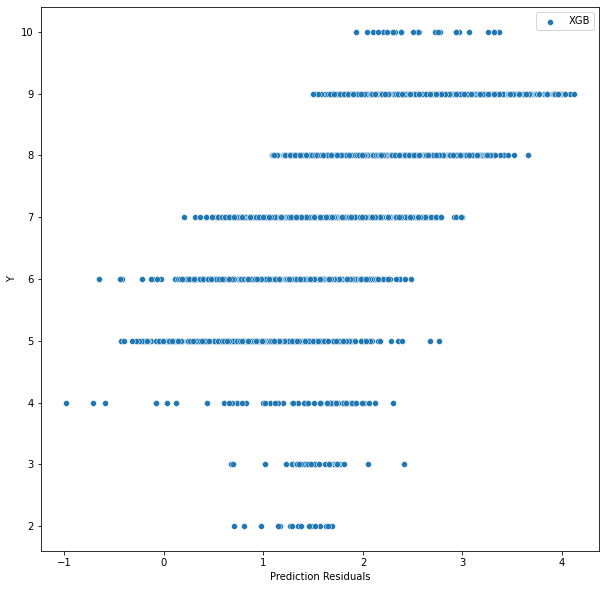

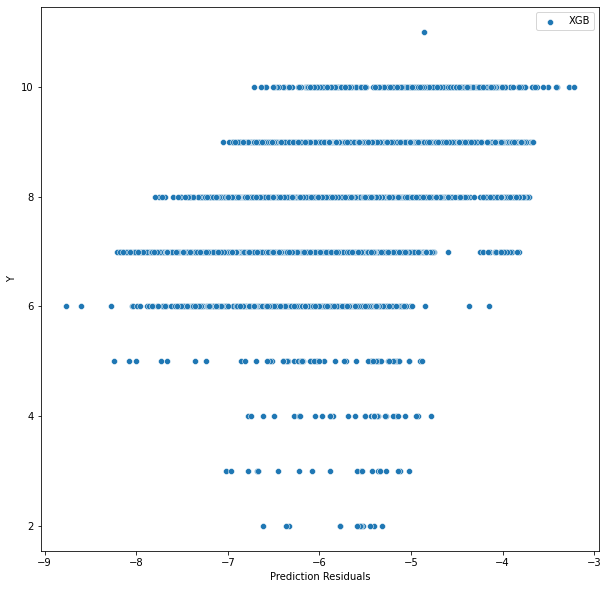

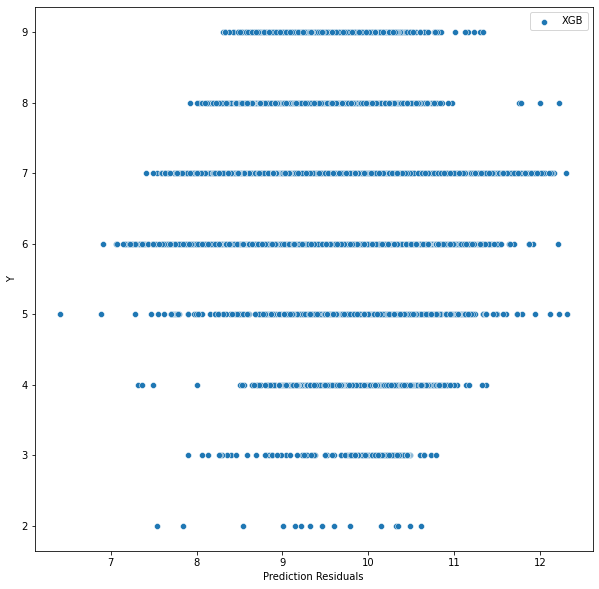

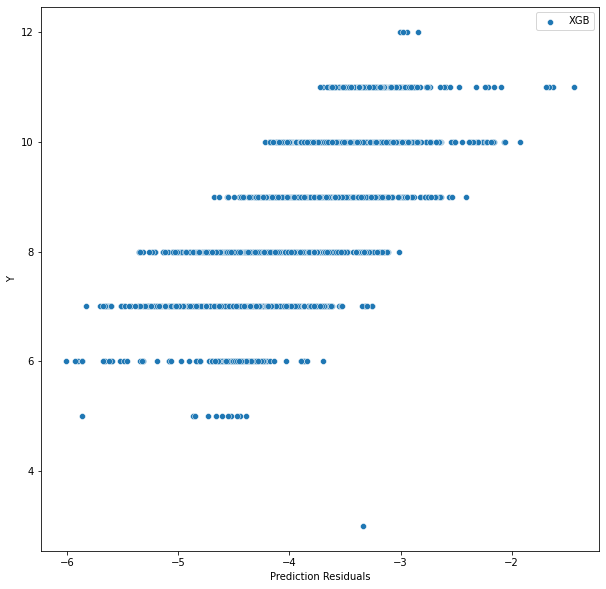

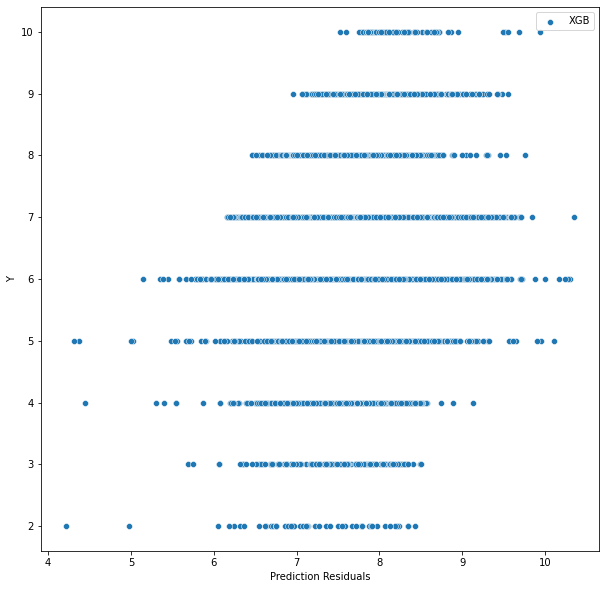

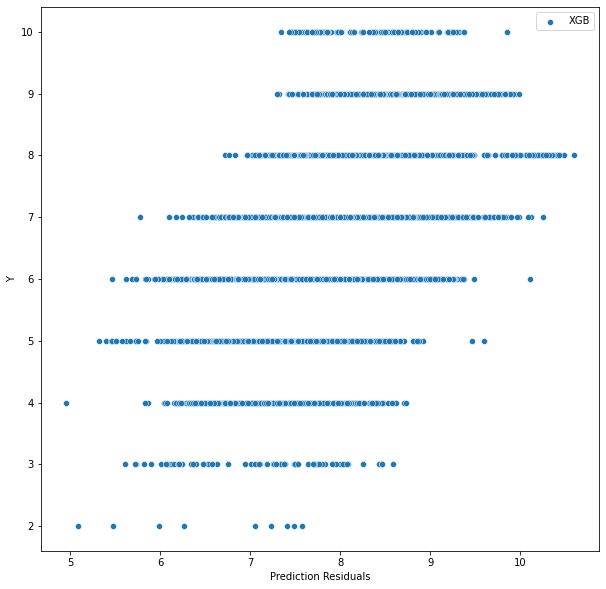

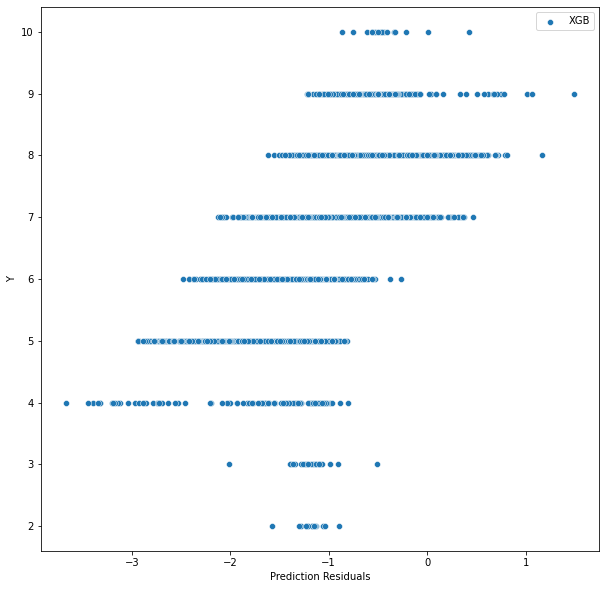

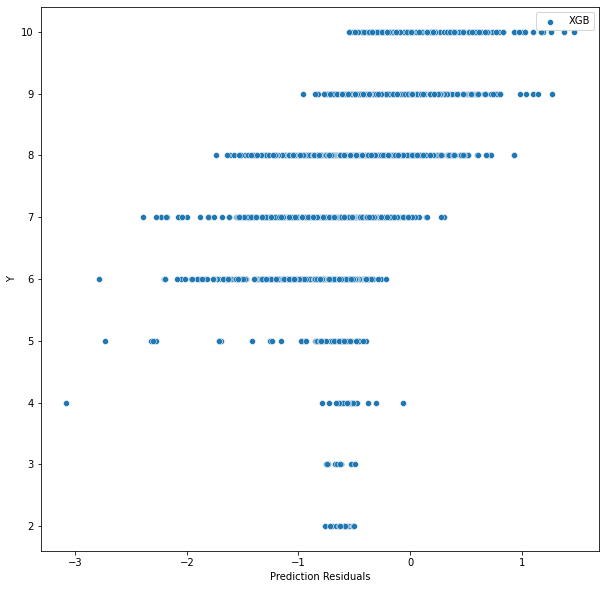

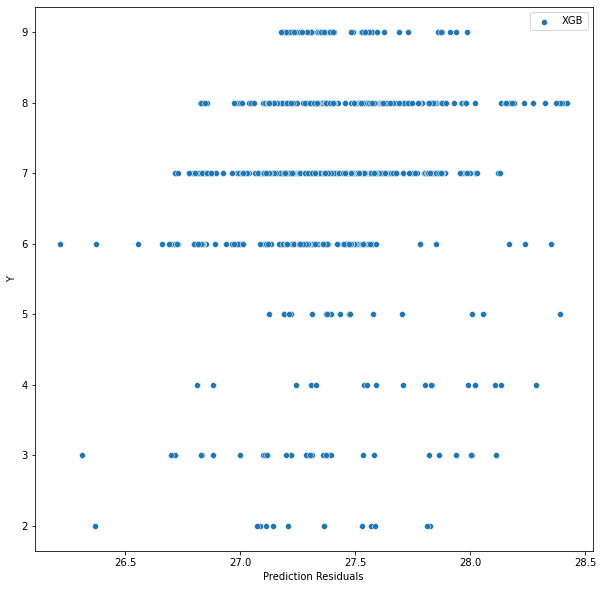

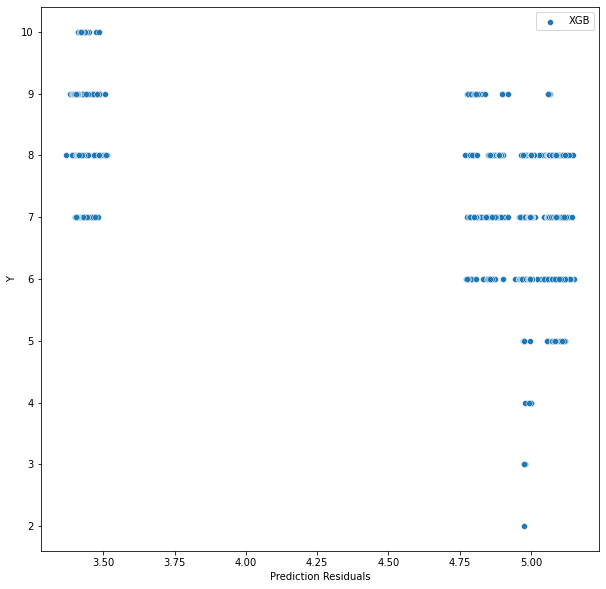

In [ ]:
# Define what column to filter on
subset_col='ART_CAT_2'

#here PLR 3
xgbr_l.fit(x_train, y_train)

# Get the unique elasticity values for each subcategory
unique_values = {'Fruitdrank': -0.374, #input elasticities to use for prediction here
'Cola': 0.996,
'Limonade & siropen': -1.731,
'Water': 0.8795,
'Speciaal fris':-1.4491,
'Sappen & smoothies':-1.4602,
'Drinkpakjes': 0.2038,
'Sinas, Lemon & Cassis': 0.1047,
'Ijsthee':-5.1726 ,
'Sport- & energydrink':-0.8043 }
# Store the results of each subset in a dictionary
results5 = {}
for key, value in unique_values.items():
    print("Running for", key,"...")
    subset = dmlset_train[dmlset_train[subset_col] == key]
    # Perform the  operation on the subset
    print(subset.columns)
    xgbr_l.fit(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE','L_AVG_SELL_PRICE','L_PRODUCT_ORDER_AMT'],axis=1), subset['L_PRODUCT_ORDER_AMT'])
    y_pred_xgb=xgbr_l.predict(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE','L_AVG_SELL_PRICE','L_PRODUCT_ORDER_AMT'],axis=1)) 
    # Store the result of the model operation in the dictionary
    theta_xgb=value

    final_y_pred_xgb_train=(subset['L_AVG_SELL_PRICE'])*(theta_xgb)+y_pred_xgb
    xgbrmsetr=mean_squared_error(final_y_pred_xgb_train,subset['L_PRODUCT_ORDER_AMT'],squared=False)
    plt.figure(figsize=(10,10))
    print(key,' plot:')
    sns.scatterplot(y=y_train,x=y_train-final_y_pred_xgb_train,label='XGB')
    plt.xlabel('Prediction Residuals')
    plt.ylabel('Y')
    results5[key] = np.corrcoef(final_y_pred_xgb_train,subset['L_AVG_SELL_PRICE'])

# Print all the results
for key, value in results5.items():
    print(f"Result for value {key}: {value}")

PLIV 2

Running for Fruitdrank ...
Running for Cola ...
Running for Limonade & siropen ...
Running for Water ...
Running for Speciaal fris ...
Running for Sappen & smoothies ...
Running for Drinkpakjes ...
Running for Sinas, Lemon & Cassis ...
Running for Ijsthee ...
Running for Sport- & energydrink ...
Result for value Fruitdrank: [[ 1.        -0.1196924]
 [-0.1196924  1.       ]]
Result for value Cola: [[1.         0.97198411]
 [0.97198411 1.        ]]
Result for value Limonade & siropen: [[ 1.        -0.9304961]
 [-0.9304961  1.       ]]
Result for value Water: [[ 1.         -0.92532653]
 [-0.92532653  1.        ]]
Result for value Speciaal fris: [[ 1.         -0.83077352]
 [-0.83077352  1.        ]]
Result for value Sappen & smoothies: [[ 1.         -0.71097705]
 [-0.71097705  1.        ]]
Result for value Drinkpakjes: [[1.        0.8662636]
 [0.8662636 1.       ]]
Result for value Sinas, Lemon & Cassis: [[1.         0.53394682]
 [0.53394682 1.        ]]
Result for value Ijsthee: [[1.     

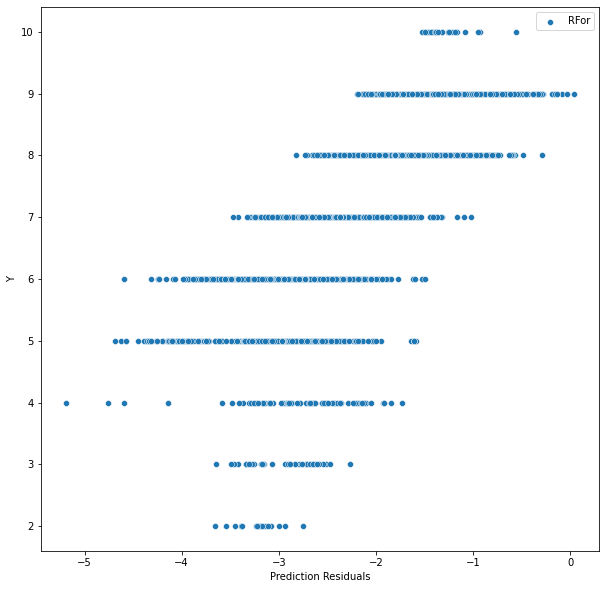

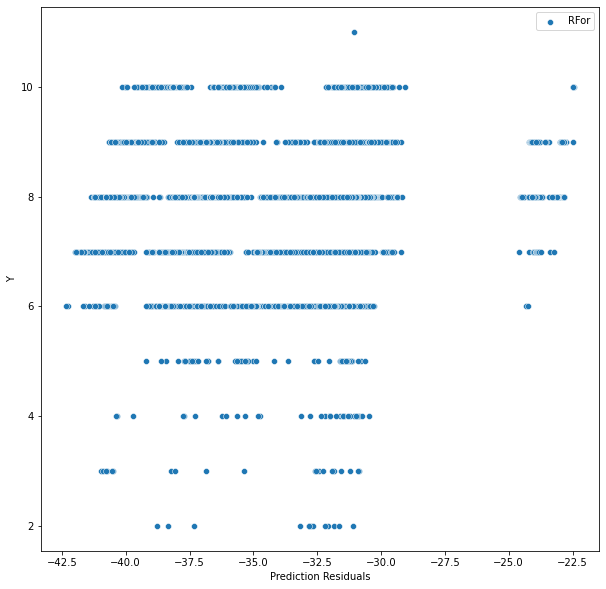

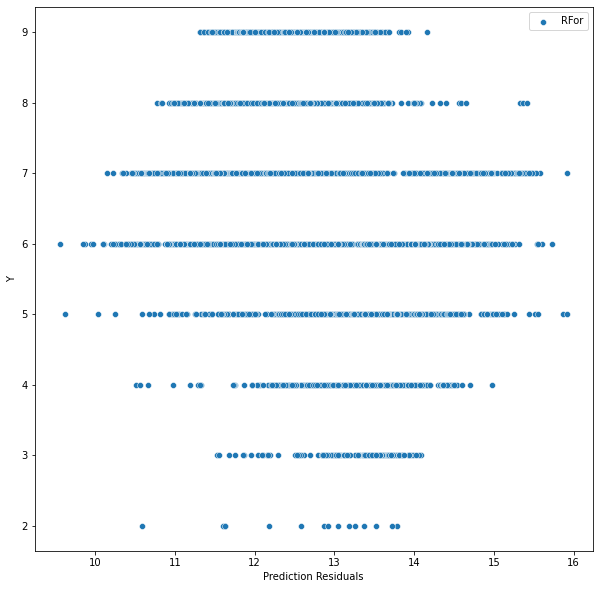

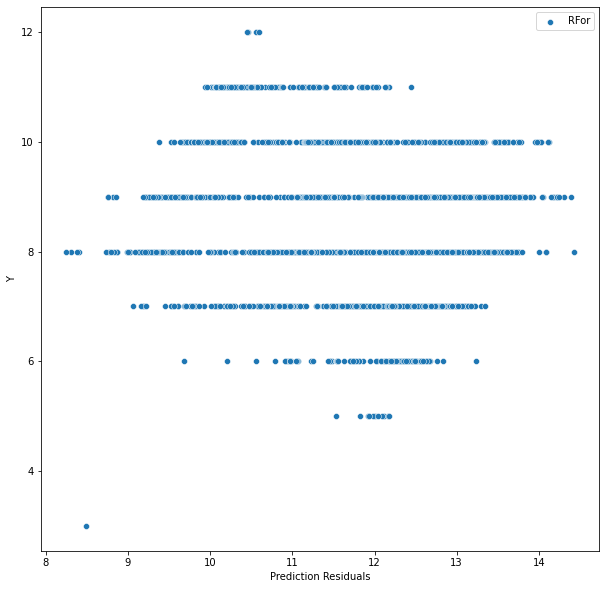

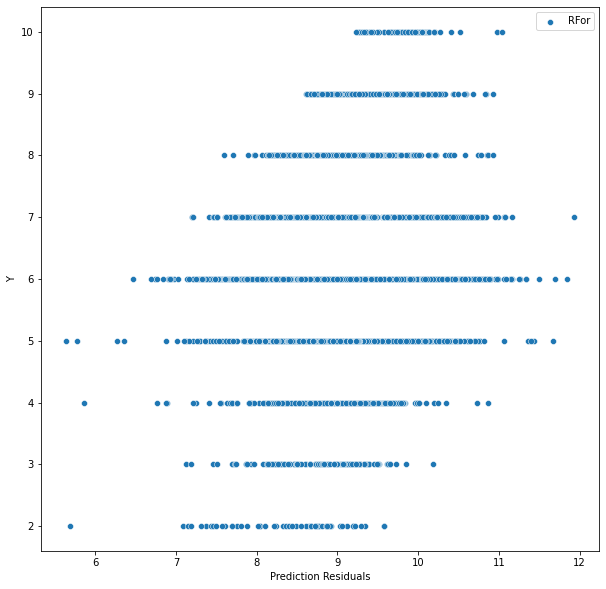

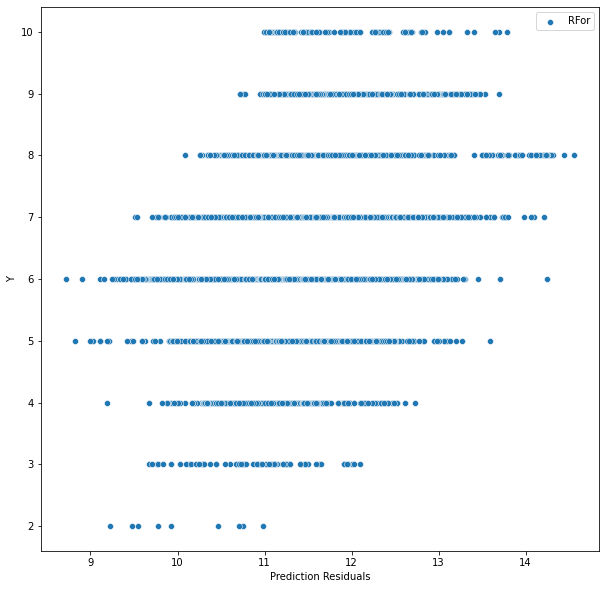

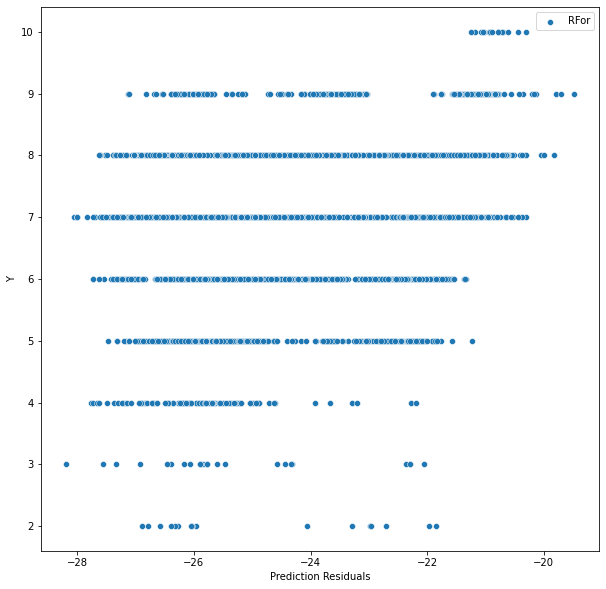

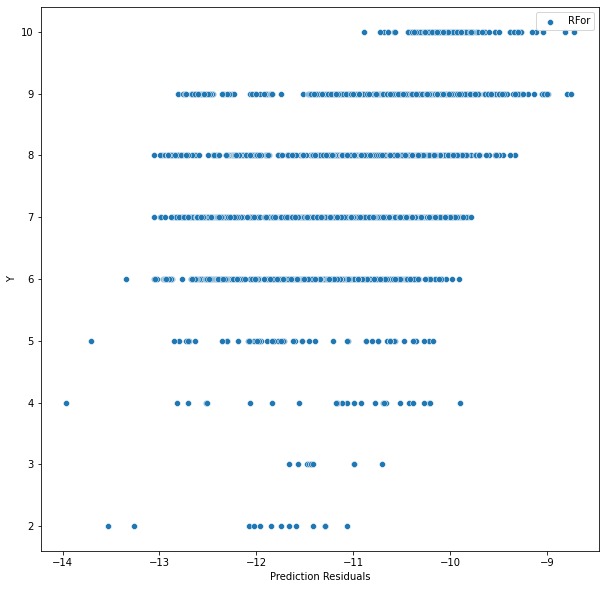

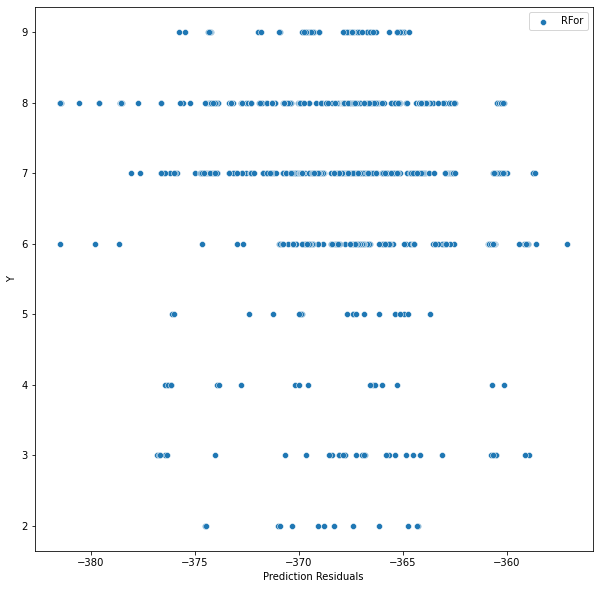

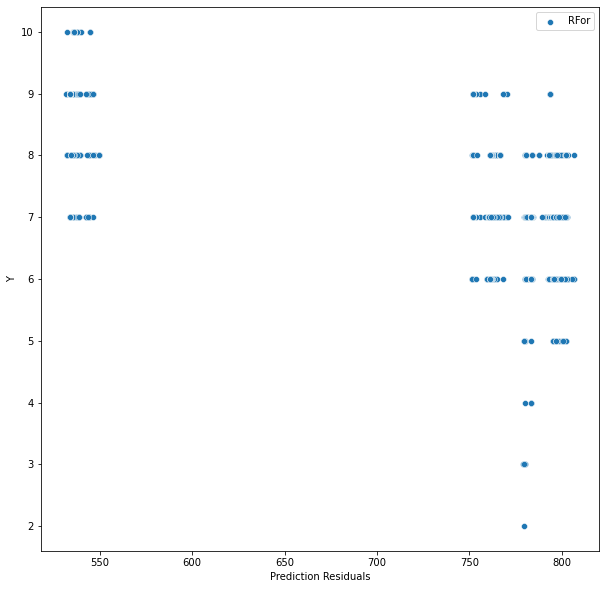

In [ ]:
# Define what column to filter on
subset_col='ART_CAT_2'

#here PLIV 2
Learnerml_l.fit(x_lasso_train,y_lasso_train)

# Get the unique elasticity values for each subcategory
unique_values = {'Fruitdrank': 0.465, #input elasticities to use for prediction here
'Cola': 5.937,
'Limonade & siropen': -2.305,
'Water': -2.675,
'Speciaal fris': -1.711,
'Sappen & smoothies':-2.148,
'Drinkpakjes': 4.6372,
'Sinas, Lemon & Cassis': 2.069,
'Ijsthee':69.4982  ,
'Sport- & energydrink':-126.095}
# Store the results of each subset in a dictionary
results5 = {}
for key, value in unique_values.items():
    print("Running for", key,"...")
    subset = dmlset_train[dmlset_train[subset_col] == key]
    # Perform the  operation on the subset
    Learnerml_l.fit(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE','L_AVG_SELL_PRICE','L_PRODUCT_ORDER_AMT'],axis=1), subset['L_PRODUCT_ORDER_AMT'])
    y_pred_rfor=Learnerml_l.predict(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE','L_AVG_SELL_PRICE','L_PRODUCT_ORDER_AMT'],axis=1)) 
    # Store the result of the model operation in the dictionary
    theta_rfor=value

    final_y_pred_rfor_train=(subset['L_AVG_SELL_PRICE'])*(theta_rfor)+y_pred_rfor
    lassormsetr=mean_squared_error(final_y_pred_rfor_train,subset['L_PRODUCT_ORDER_AMT'],squared=False)
    plt.figure(figsize=(10,10))
    print(key,' plot:')
    sns.scatterplot(y=y_train,x=y_train-final_y_pred_rfor_train,label='RFor')
    plt.xlabel('Prediction Residuals')
    plt.ylabel('Y')
    results5[key] = np.corrcoef(final_y_pred_rfor_train,subset['L_AVG_SELL_PRICE'])

# Print all the results
for key, value in results5.items():
    print(f"Result for value {key}: {value}")

PLIV 3

In [ ]:
# Define what column to filter on
subset_col='ART_CAT_2'

#here PLIV 3

# Get the unique elasticity values for each subcategory
unique_values = {'Fruitdrank': 0.4831, #input elasticities to use for prediction here
'Cola': 5.9908,
'Limonade & siropen': -2.5547,
'Water':-0.4736,
'Speciaal fris':-1.3547,
'Sappen & smoothies':-2.0189,
'Drinkpakjes': 2.1885,
'Sinas, Lemon & Cassis':1.8233,
'Ijsthee':19.5462,
'Sport- & energydrink':5.9894}
# Store the results of each subset in a dictionary
results5 = {}
for key, value in unique_values.items():
    print("Running for", key,"...")
    subset = dmlset_train[dmlset_train[subset_col] == key]
    # Perform the  operation on the subset
    xgbr_l.fit(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE','L_AVG_SELL_PRICE','L_PRODUCT_ORDER_AMT'],axis=1), subset['L_PRODUCT_ORDER_AMT'])
    y_pred_xgb=xgbr_l.predict(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE','L_AVG_SELL_PRICE','L_PRODUCT_ORDER_AMT'],axis=1)) 
    # Store the result of the model operation in the dictionary
    theta_xgb=value

    final_y_pred_xgb_train=(subset['L_AVG_SELL_PRICE'])*(theta_xgb)+y_pred_xgb
    xgbrmsetr=mean_squared_error(final_y_pred_xgb_train,subset['L_PRODUCT_ORDER_AMT'],squared=False)
    plt.figure(figsize=(10,10))
    print(key,' plot:')
    sns.scatterplot(y=y_train,x=y_train-final_y_pred_xgb_train,label='XGB')
    plt.xlabel('Prediction Residuals')
    plt.ylabel('Y')
    results5[key] = np.corrcoef(final_y_pred_xgb_train,subset['L_AVG_SELL_PRICE'])

# Print all the results
for key, value in results5.items():
    print(f"Result for value {key}: {value}")

# Deprecated: Lasso

PLIV : 

In [ ]:
lasso_l = LassoCV(fit_intercept=True, cv=10)
lasso_m = LassoCV(fit_intercept=True, cv=10)
lasso_r = LassoCV(fit_intercept=True, cv=10)

In [ ]:
# Define what column to filter on
subset_col='ART_CAT_2'

# Get the unique values of the column that we want to use for dividing the subsets
unique_values = dmlset_lasso_train[subset_col].unique()
# Store the results of each subset in a dictionary
results2 = {}
for value in unique_values:
    print("Running for", value,"...")
    subset = dmlset_lasso_train[dmlset_lasso_train[subset_col] == value]
    # Perform the model operation on the subset
    
    obj_dml_data = dml.DoubleMLData(subset.drop('ART_CAT_2',axis=1), y_col='L_PRODUCT_ORDER_AMT', d_cols='L_AVG_SELL_PRICE', z_cols='L_AVG_PURCHASE_PRICE',  force_all_x_finite=True)
    #print(obj_dml_data)
    dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, lasso_l,lasso_m,lasso_r)
    print(dml_pliv_obj.fit())
    result = dml_pliv_obj.coef
    # Store the result of the model operation in the dictionary
    results2[value] = result

# Print all the results
for key, value in results2.items():
    print(f"Result for value {key}: {value}")

Running for Fruitdrank ...
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): ['L_AVG_PURCHASE_PRICE']
No. Observations: 12313

------------------ S

PLR:

In [ ]:

# Define what column to filter on
subset_col='ART_CAT_2'

# Get the unique values of the column that we want to use for dividing the subsets
unique_values = dmlset_lasso_train[subset_col].unique()
# Store the results of each subset in a dictionary
results4 = {}
for value in unique_values:
    print("Running for", value,"...")
    subset = dmlset_lasso_train[dmlset_lasso_train[subset_col] == value]
    # Perform the model operation on the subset
    obj_dml_data = dml.DoubleMLData(subset.drop(['ART_CAT_2','L_AVG_PURCHASE_PRICE'],axis=1), y_col='L_PRODUCT_ORDER_AMT', d_cols='L_AVG_SELL_PRICE', force_all_x_finite=True)
    dml_pliv_obj = dml.DoubleMLPLR(obj_dml_data, lasso_l,lasso_r)
    print(dml_pliv_obj.fit())
    result = dml_pliv_obj.coef
    # Store the result of the model operation in the dictionary
    results4[value] = result

# Print all the results
for key, value in results4.items():
    print(f"Result for value {key}: {value}")